In [1]:
import numpy as np
import matplotlib.pyplot as plt
from picca import constants as picca_constants
from scipy import constants as scipy_constants

In [2]:
# MW21 cosmology values
hubble, z = 0.71, 2.5
omegab, omegam = 0.046, 0.27
omegal = 1 - omegam
ns = 0.96

# f(Nhi, X)

In [3]:
def f_Nhi(colden, k, b):
    y = k*(colden**b)
    return y

Their description of f_Nhi is a broken potential function, with one segment for 19 < logNhi < 20.3 cm^-2 and the other 20.3 < logNhi < 22 cm^-2 
The parameters b1 and b2 are given in the paper. k1 and k2 are determinated so that:
- the integration of f_nhi from logNhi=19 to logNhi=20.3 (cm^-2) is 0.1
- f_Nhi(k1, b1) = f_Nhi(k2, b2) at logNhi = 20.3

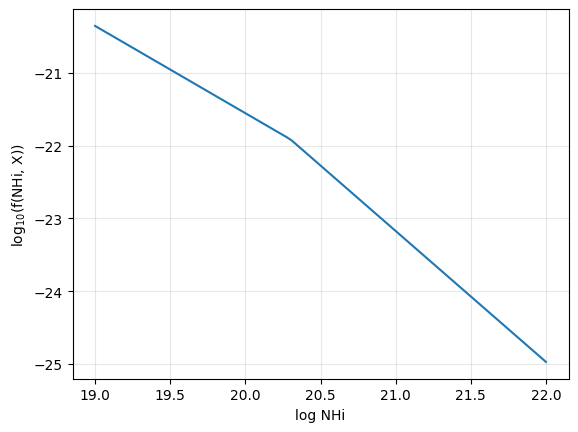

In [4]:
k1, b1 = 280.14, -1.2
k2, b2 = 4.24e14, -1.8

NHirange_mw11 = np.logspace(np.log10(19), np.log10(22), 100)
colden1, colden2 = NHirange_mw11[NHirange_mw11 < 20.3], NHirange_mw11[NHirange_mw11 >= 20.3]
fnhi_mw11 = np.concatenate([f_Nhi(10**colden1, k1, b1), f_Nhi(10**colden2, k2, b2)])

plt.plot(NHirange_mw11, np.log10(fnhi_mw11))
plt.xlabel('log NHi')
plt.ylabel(r'log$_{10}$(f(NHi, X))')
plt.grid(alpha=0.3);

With this f_Nhi we can define the column density distribution function as:

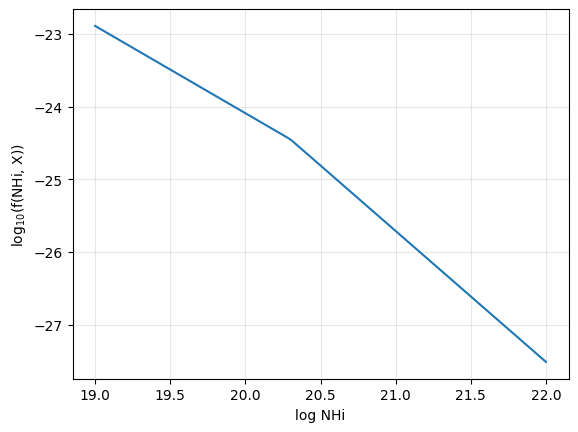

In [5]:
c_kms = scipy_constants.speed_of_light*1e-3  # kms^-1
cddf_mw11 = fnhi_mw11*100*hubble*((1+z)**2)/c_kms

plt.plot(NHirange_mw11, np.log10(cddf_mw11))
plt.xlabel('log NHi')
plt.ylabel(r'log$_{10}$(f(NHi, X))')
plt.grid(alpha=0.3);

# Absorption profiles and equivalent width

## Voigt profile

In [6]:
from w1_w2 import wave_to_fft_profile

d(k_los = 0, logNHi = 19) = 8.03
d(k_los = 0, logNHi = 20) = 25.31
d(k_los = 0, logNHi = 21) = 79.71


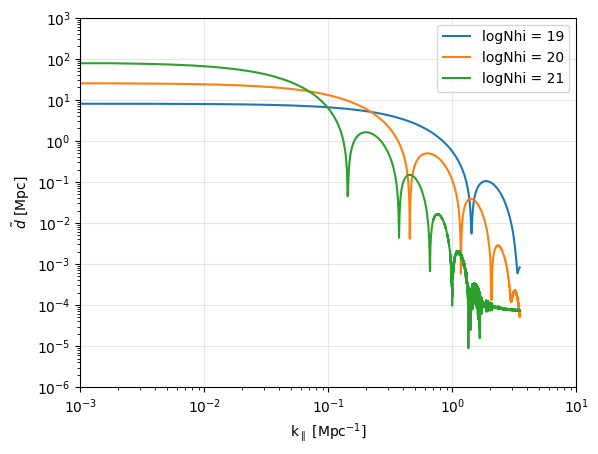

In [7]:
wave_log = np.linspace(np.log10(2800), np.log10(6800), 2**12) # Angstrom
wave = 10**wave_log

NHirange = [19, 20, 21]

for i, nhi_value in enumerate(NHirange):
    k_w1w2, d_voigt, Deltax = wave_to_fft_profile(wave, z, nhi_value, omegam=omegam, omegal=omegal, hubble=hubble)
    plt.plot(k_w1w2, d_voigt, label='logNhi = %.0f' %nhi_value)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(1e-3, 1e1)
    plt.ylim(1e-6, 1e3)
    plt.xlabel(r'k$_\parallel$ [Mpc$^{-1}$]')
    plt.ylabel(r'$\tilde{d}$ [Mpc]')
    plt.grid(alpha=0.3)
    plt.legend();
    print('d(k_los = 0, logNHi = %.0f) = %.2f' %(nhi_value, d_voigt[0]))

In [8]:
from w1_w2 import get_voigt_profile_wave, profile_wave_to_comov_dist

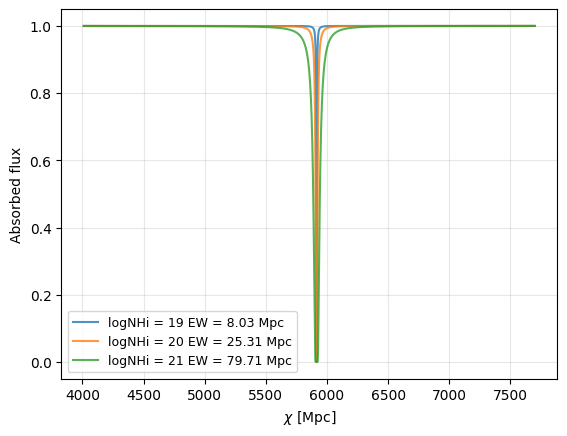

In [9]:
wave_log = np.linspace(np.log10(2800), np.log10(6800), 2**12) # Angstrom
wave = 10**wave_log

NHirange = [19, 20, 21]

for i, nhi_value in enumerate(NHirange):
    flux_wavelength = get_voigt_profile_wave(wave, z, nhi_value)
    comov, flux_voigt = profile_wave_to_comov_dist(wave, flux_wavelength, omegam, hubble)
    ew_voigt = np.trapezoid(1-flux_voigt, comov)
    plt.plot(comov, flux_voigt, alpha=0.8, label='logNHi = %.0f EW = %.2f Mpc' %(nhi_value, ew_voigt))
    plt.xlabel(r'$\chi$ [Mpc]')
    plt.ylabel(r'Absorbed flux')
    plt.grid(alpha=0.3)
    plt.legend(loc='lower left', fontsize=9);


Good

## Absorption profile MW11

In [10]:
from astropy.cosmology import FlatLambdaCDM
cosmo_astropy = FlatLambdaCDM(H0=hubble*100, Om0=omegam, Ob0=omegab)

In [11]:
from w1_w2 import fft_profile

In [12]:
wave_log = np.linspace(np.log10(2800), np.log10(6800), 2**12) # Angstrom
wave = 10**wave_log

lambda_lya = picca_constants.ABSORBER_IGM["LYA"]
z_value = wave/lambda_lya - 1
xi = np.array(cosmo_astropy.comoving_distance(z_value))  # Mpc 
xi_lin = np.linspace(xi.min(), xi.max(), len(xi))  # We will need this for later
xi0 = np.array(cosmo_astropy.comoving_distance(z))  # Mpc


d(k_los = 0, logNHi = 19) = 7.92
d(k_los = 0, logNHi = 20) = 25.01
d(k_los = 0, logNHi = 21) = 78.72


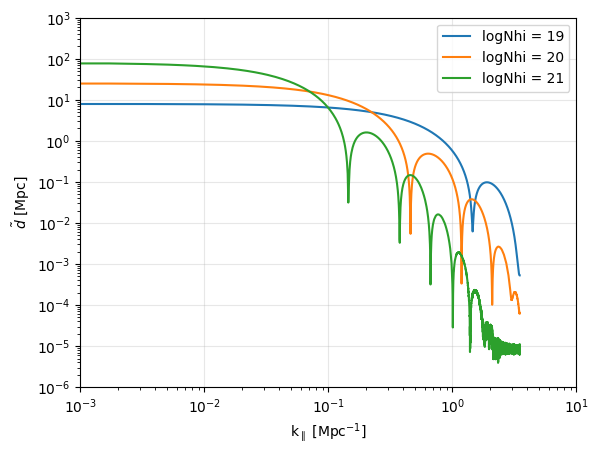

In [13]:
NHirange = [19, 20, 21]
kappa2 = 5e-19

for nhi_value in NHirange:
    y = np.exp(-((10**nhi_value)*kappa2/((xi-xi0)**2)))
    # We need y to be linearly spaced for the fft
    y_lin = np.interp(xi_lin, xi, y)
    k_mw11, d_mw11 = fft_profile(1-y_lin, dx=xi_lin[1]-xi_lin[0])
    plt.plot(k_mw11, d_mw11, label='logNhi = %.0f' %nhi_value)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(1e-3, 1e1)
    plt.ylim(1e-6, 1e3)
    plt.xlabel(r'k$_\parallel$ [Mpc$^{-1}$]')
    plt.ylabel(r'$\tilde{d}$ [Mpc]')
    plt.grid(alpha=0.3)
    plt.legend()
    print('d(k_los = 0, logNHi = %.0f) = %.2f' %(nhi_value, d_mw11[0]))

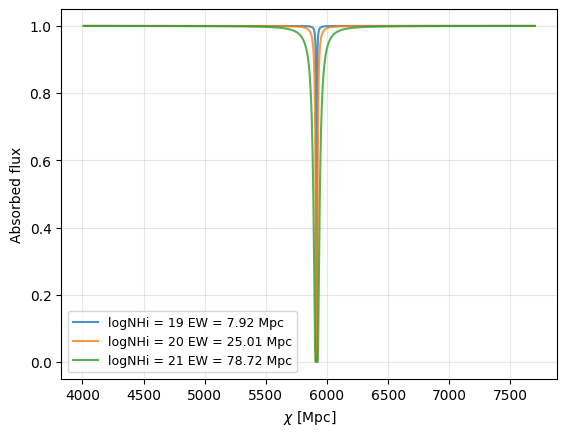

In [14]:
NHirange = [19, 20, 21]
kappa2 = 5e-19

for nhi_value in NHirange:
    y = np.exp(-((10**nhi_value)*kappa2/((xi-xi0)**2)))
    # We need y to be linearly spaced for the fft
    y_lin = np.interp(xi_lin, xi, y)
    ew_mw11 = np.trapezoid(1-y_lin, xi_lin)

    plt.plot(xi, y, alpha=0.8, label='logNHi = %.0f EW = %.2f Mpc' %(nhi_value, ew_mw11))
    plt.xlabel(r'$\chi$ [Mpc]')
    plt.ylabel(r'Absorbed flux')
    plt.grid(alpha=0.3)
    plt.legend(loc='lower left', fontsize=9);
    

Great! It matches perfectly

# w1 and w2

## Voigt model

In [6]:
from w1_w2 import wave_to_fft_profile

wave_log = np.linspace(np.log10(2800), np.log10(6800), 2**12) # Angstrom
wave = 10**wave_log

d, w2_int, w1_int, ew = [], [], [], []
for i, nhi_value in enumerate(NHirange_mw11):
    k_voigt, d_voigt, delta_x = wave_to_fft_profile(wave, z, nhi_value, omegam, omegal, hubble)
    d.append(d_voigt)
    w1_int.append(cddf_mw11[i]*(d_voigt**2)*np.log(10)*(10**nhi_value))
    w2_int.append(cddf_mw11[i]*d_voigt*np.log(10)*(10**nhi_value))

d_voigt, w2_int, w1_int = np.array(d), np.array(w2_int), np.array(w1_int)
w1_voigt = np.trapezoid(w1_int, NHirange_mw11, axis=0)  # Logarithmic integration
w2_voigt = np.trapezoid(w2_int, NHirange_mw11, axis=0)  # Logarithmic integration

## MW11 model

In [7]:
from astropy.cosmology import FlatLambdaCDM
cosmo_astropy = FlatLambdaCDM(H0=hubble*100, Om0=omegam, Ob0=omegab)
from w1_w2 import fft_profile

wave_log = np.linspace(np.log10(2800), np.log10(6800), 2**12) # Angstrom
wave = 10**wave_log

lambda_lya = picca_constants.ABSORBER_IGM["LYA"]
z_value = wave/lambda_lya - 1
xi = np.array(cosmo_astropy.comoving_distance(z_value))  # Mpc 
xi_lin = np.linspace(xi.min(), xi.max(), len(xi))  # We will need this for later
xi0 = np.array(cosmo_astropy.comoving_distance(z))  # Mpc
kappa2 = 5e-19

d, w2_int, w1_int = [], [], []
for i, nhi_value in enumerate(NHirange_mw11):
    y = np.exp(-((10**nhi_value)*kappa2/((xi-xi0)**2)))
    # We need y to be linearly spaced for the fft
    y_lin = np.interp(xi_lin, xi, y)
    k_mw11, d_mw11 = fft_profile(1-y_lin, dx=xi_lin[1]-xi_lin[0])
    d.append(d_mw11)
    w1_int.append(cddf_mw11[i]*(d_mw11**2)*np.log(10)*(10**nhi_value))
    w2_int.append(cddf_mw11[i]*d_mw11*np.log(10)*(10**nhi_value))

d_mw11, w2_int, w1_int = np.array(d), np.array(w2_int), np.array(w1_int)
w1_mw11 = np.trapezoid(w1_int, NHirange_mw11, axis=0)  # Logarithmic integration
w2_mw11 = np.trapezoid(w2_int, NHirange_mw11, axis=0)  # Logarithmic integration

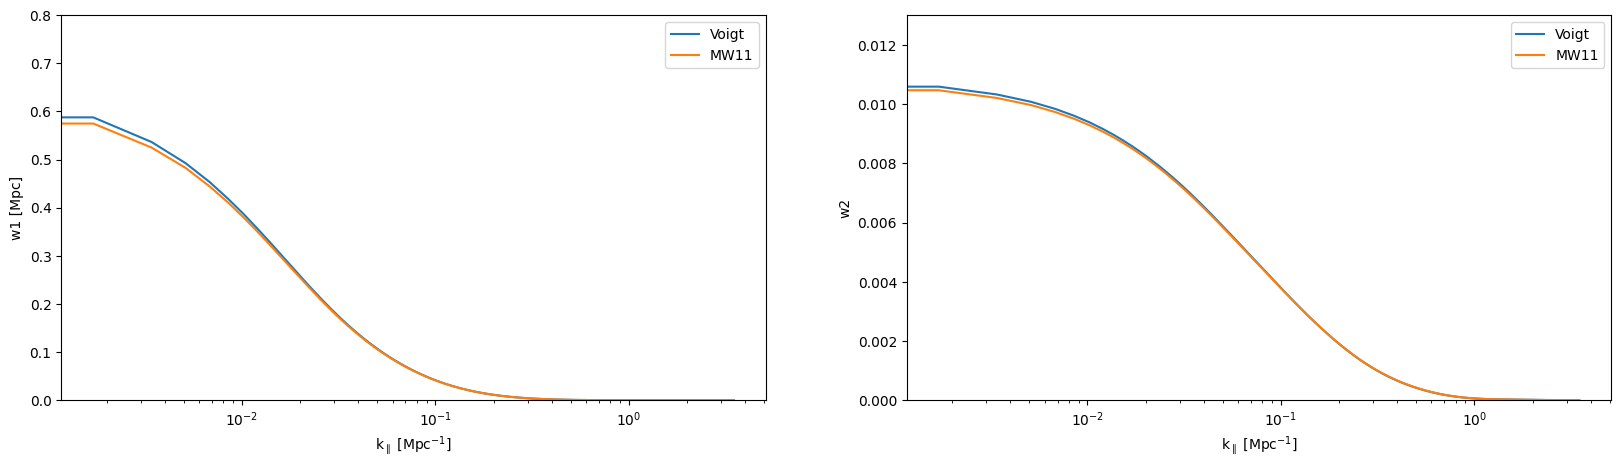

In [8]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(k_voigt, w1_voigt, label='Voigt')
plt.plot(k_mw11, w1_mw11, label='MW11')
plt.ylabel(r'w1 [Mpc]')
plt.xscale('log')
plt.xlabel(r'k$_\parallel$ [Mpc$^{-1}$]')
plt.ylim(0, 0.8)
plt.legend();

plt.subplot(1, 2, 2)
plt.plot(k_voigt, w2_voigt, label='Voigt')
plt.plot(k_mw11, w2_mw11, label='MW11')
plt.ylabel(r'w2')
plt.xscale('log')
plt.xlabel(r'k$_\parallel$ [Mpc$^{-1}$]')
plt.ylim(0, 0.013)
plt.legend();

In [40]:
print(r'W2(kpar = 0) =', w2_mw11[0], '-Using MW11 absorption profile')
print(r'W2(kpar = 0) =', w2_voigt[0], '-Using Voigt absorption profile')

W2(kpar = 0) = 0.010667915323853703 -Using MW11 absorption profile
W2(kpar = 0) = 0.010802133126033063 -Using Voigt absorption profile


Is it the same as when using the equivalent width (equivalent width = d(k=0))?

In [42]:
a = np.trapezoid(np.log(10)*(10**NHirange_mw11)*cddf_mw11*d_mw11[:, 0], NHirange_mw11)
b = np.trapezoid(np.log(10)*(10**NHirange_mw11)*cddf_mw11*d_voigt[:, 0], NHirange_mw11)
print(r'W2(kpar = 0) =', a, '-Using MW11 equivalent width')
print(r'W2(kpar = 0) =', b, '-Using Voigt equivalent width')

W2(kpar = 0) = 0.010667915323853708 -Using MW11 equivalent width
W2(kpar = 0) = 0.010802133126033064 -Using Voigt equivalent width


# Tan et al 2025 figure

In [24]:
Fmean_hcd = 0.9779275149014024

In [3]:
k1, b1 = 280.14, -1.2
k2, b2 = 4.24e14, -1.8

c_kms = scipy_constants.speed_of_light*1e-3  # km/s

def f_Nhi(colden, k, b):
    y = k*(colden**b)
    return y

In [38]:
nhi_range1 = np.logspace(np.log10(17.3), np.log10(18.3))
cddf1 = f_Nhi(10**nhi_range1, k1, b1)*100*hubble*((1+z)**2)/c_kms
nhi_range2 = np.logspace(np.log10(18.3), np.log10(19.3))
cddf2 = f_Nhi(10**nhi_range2, k1, b1)*100*hubble*((1+z)**2)/c_kms
nhi_range3 = np.logspace(np.log10(19.3), np.log10(20.3))
cddf3 = f_Nhi(10**nhi_range3, k1, b1)*100*hubble*((1+z)**2)/c_kms
# Change of parameters for the cddf
nhi_range4 = np.logspace(np.log10(20.3), np.log10(21.3))
cddf4 = f_Nhi(10**nhi_range4, k2, b2)*100*hubble*((1+z)**2)/c_kms
nhi_range5 = np.logspace(np.log10(21.3), np.log10(22.5))
cddf5 = f_Nhi(10**nhi_range5, k2, b2)*100*hubble*((1+z)**2)/c_kms
nhi_range6 = np.logspace(np.log10(17.3), np.log10(20.3))
cddf6 = f_Nhi(10**nhi_range6, k1, b1)*100*hubble*((1+z)**2)/c_kms
nhi_range7 = np.logspace(np.log10(17.3), np.log10(22.5))
colden1, colden2 = nhi_range7[nhi_range7 < 20.3], nhi_range7[nhi_range7 >= 20.3]
cddf7 = np.concatenate([f_Nhi(10**colden1, k1, b1), f_Nhi(10**colden2, k2, b2)])*100*hubble*((1+z)**2)/c_kms


In [39]:
list_nhi = [nhi_range1, nhi_range2, nhi_range3, nhi_range4, nhi_range5, nhi_range6, nhi_range7]
list_cddf = [cddf1, cddf2, cddf3, cddf4, cddf5, cddf6, cddf7]
list_color = ['k', 'b', 'orange', 'red', 'pink', 'slategrey', 'green']

## Voigt model

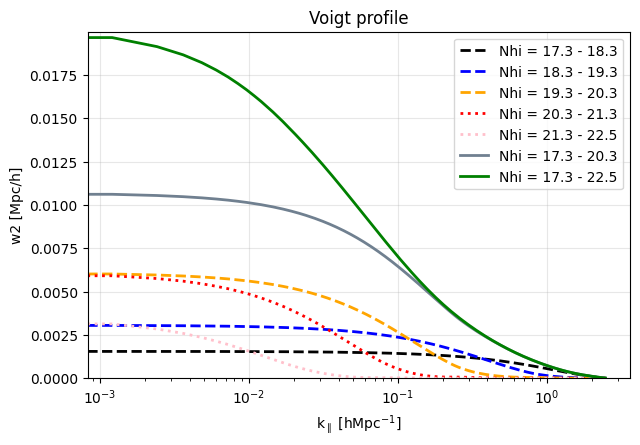

In [67]:
from w1_w2 import wave_to_fft_profile

wave_log = np.linspace(np.log10(2800), np.log10(6800), 2**12) # Angstrom
wave = 10**wave_log

plt.figure(figsize=(7, 4.5))

for number in [0, 1, 2, 3, 4, 5, 6]:
    nhi_range, cddf = list_nhi[number], list_cddf[number]
    color = list_color[number]

    if number == 0 or number == 1 or number == 2:
        linestyle = '--'
    elif number == 3 or number == 4:
        linestyle = ':'
    else:
        linestyle = '-'

    w2_int = []
    for i, nhi_value in enumerate(nhi_range):
        k_voigt, d_voigt, delta_x = wave_to_fft_profile(wave, z, nhi_value, omegam, omegal, hubble)
        w2_int.append(cddf[i]*d_voigt*np.log(10)*(10**nhi_value))

    w2_int = np.array(w2_int)
    w2_voigt = np.trapezoid(w2_int, nhi_range, axis=0)  # Logarithmic integration
    w2_voigt /= Fmean_hcd

    plt.plot(k_voigt*hubble, w2_voigt/hubble, color=color, linestyle=linestyle, linewidth=2, label='Nhi = %.1f - %.1f' %(nhi_range.min(), nhi_range.max()))
    plt.ylabel(r'w2 [Mpc/h]')
    plt.yticks(np.arange(0, 0.0200, 0.0025))
    plt.xscale('log')
    plt.xlabel(r'k$_\parallel$ [hMpc$^{-1}$]')
    plt.legend()
    plt.ylim(0, 0.0200)
    plt.grid(alpha=0.3)
    plt.title('Voigt profile');


## MW11 model

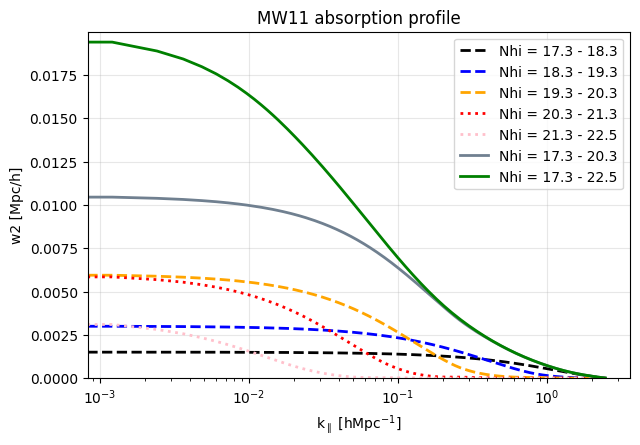

In [66]:
from astropy.cosmology import FlatLambdaCDM
cosmo_astropy = FlatLambdaCDM(H0=hubble*100, Om0=omegam, Ob0=omegab)
from w1_w2 import fft_profile

wave_log = np.linspace(np.log10(2800), np.log10(6800), 2**12) # Angstrom
wave = 10**wave_log

lambda_lya = picca_constants.ABSORBER_IGM["LYA"]
z_value = wave/lambda_lya - 1
xi = np.array(cosmo_astropy.comoving_distance(z_value))  # Mpc 
xi_lin = np.linspace(xi.min(), xi.max(), len(xi))  # We will need this for later
xi0 = np.array(cosmo_astropy.comoving_distance(z))  # Mpc
kappa2 = 5e-19

plt.figure(figsize=(7, 4.5))

for number in [0, 1, 2, 3, 4, 5, 6]:
    nhi_range, cddf = list_nhi[number], list_cddf[number]
    color = list_color[number]

    if number == 0 or number == 1 or number == 2:
        linestyle = '--'
    elif number == 3 or number == 4:
        linestyle = ':'
    else:
        linestyle = '-'

    w2_int = []
    for i, nhi_value in enumerate(nhi_range):
        y = np.exp(-((10**nhi_value)*kappa2/((xi-xi0)**2)))
        # We need y to be linearly spaced for the fft
        y_lin = np.interp(xi_lin, xi, y)
        k_mw11, d_mw11 = fft_profile(1-y_lin, dx=xi_lin[1]-xi_lin[0])
        w2_int.append(cddf[i]*d_mw11*np.log(10)*(10**nhi_value))

    w2_int = np.array(w2_int)
    w2_mw11 = np.trapezoid(w2_int, nhi_range, axis=0)  # Logarithmic integration
    w2_mw11 /= Fmean_hcd

    plt.plot(k_mw11*hubble, w2_mw11/hubble, color=color, linestyle=linestyle, linewidth=2, label='Nhi = %.1f - %.1f' %(nhi_range.min(), nhi_range.max()))
    plt.ylabel(r'w2 [Mpc/h]')
    plt.yticks(np.arange(0, 0.0200, 0.0025))
    plt.xscale('log')
    plt.xlabel(r'k$_\parallel$ [hMpc$^{-1}$]')
    plt.legend()
    plt.ylim(0, 0.0200)
    plt.grid(alpha=0.3)
    plt.title('MW11 absorption profile');


# Exploring w2

In [4]:
k1, b1 = 280.14, -1.2
k2, b2 = 4.24e14, -1.8

c_kms = scipy_constants.speed_of_light*1e-3  # km/s

def f_Nhi(colden, k, b):
    y = k*(colden**b)
    return y

In [43]:
nhi_range = np.logspace(np.log10(19), np.log10(19.2), 5)
cddf = f_Nhi(10**nhi_range, k1, b1)*100*hubble*((1+z)**2)/c_kms

9.962289247386643e-24 19.09986910900581


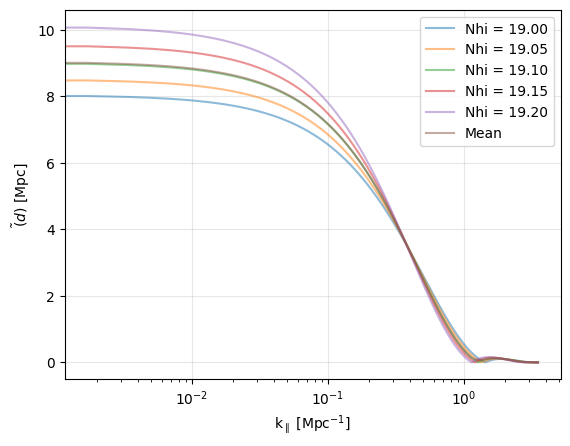

In [44]:
from w1_w2 import wave_to_fft_profile

wave_log = np.linspace(np.log10(2800), np.log10(6800), 2**12) # Angstrom
wave = 10**wave_log

plt.figure()
w2_int, ds = [], []
for i, nhi_value in enumerate(nhi_range):
    k_voigt, d_voigt, delta_x = wave_to_fft_profile(wave, z, nhi_value, omegam, omegal, hubble)
    w2_int.append(cddf[i]*d_voigt*np.log(10)*(10**nhi_value))
    ds.append(d_voigt)
    plt.plot(k_voigt, d_voigt, alpha=0.5, label='Nhi = %.2f' %(nhi_value))


w2_int, ds = np.array(w2_int), np.array(ds)
w2_voigt = np.trapezoid(w2_int, nhi_range, axis=0)  # Logarithmic integration

cddf_mean = np.mean(cddf)
nhi_mean = np.mean(nhi_range)
d_mean = np.mean(ds, axis=0)
print(cddf_mean, nhi_mean)
plt.plot(k_voigt, d_mean, alpha=0.5, label='Mean')
plt.ylabel(r'$\tilde(d)$ [Mpc]')
plt.xscale('log')
plt.xlabel(r'k$_\parallel$ [Mpc$^{-1}$]')
plt.legend() 
plt.grid(alpha=0.3);

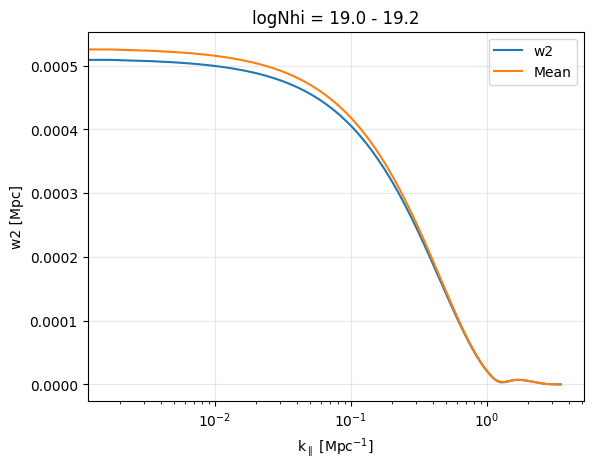

In [45]:
plt.figure()
plt.plot(k_voigt, w2_voigt, label='w2')
plt.plot(k_voigt, d_mean*cddf_mean*np.log(10)*np.trapezoid(10**nhi_range, nhi_range), label='Mean')
plt.ylabel(r'w2 [Mpc]')
plt.xscale('log')
plt.xlabel(r'k$_\parallel$ [Mpc$^{-1}$]')
plt.legend()
plt.grid(alpha=0.3)
plt.title('logNhi = %.1f - %.1f' %(nhi_range.min(), nhi_range.max()));
